In [10]:
! pip install varclushi

In [11]:
import pickle
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from functools import reduce
from varclushi import VarClusHi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint

## Get data from Big Query

In [12]:
%%bigquery df
SELECT
    id
    ,symbol
    ,name
    ,date
    ,market_data.current_price as current_price
    ,market_data.market_cap as market_cap
    ,market_data.total_volume as total_volume  
FROM
    `crispy-computing-machine.crispy_dwh.crypto_btc`

Downloading: 100%|██████████| 1909/1909 [00:01<00:00, 1863.84rows/s]


Create a column for time ordered by day

In [13]:
df["date"]=pd.to_datetime(df["date"])
df=df[df["date"]>=datetime.datetime(2021, 1, 1)]
df.sort_values(by=["date"],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)
df.reset_index(drop=False,inplace=True)
df.rename(columns={"index":"t"},inplace=True)

Summary of our dataframe

In [14]:
completitud=pd.DataFrame((1-df.isnull().sum()/df.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,t,100.0,0,int64
1,id,100.0,0,object
2,symbol,100.0,0,object
3,name,100.0,0,object
4,date,100.0,0,datetime64[ns]
5,current_price,100.0,0,float64
6,market_cap,100.0,0,float64
7,total_volume,100.0,0,float64


## Feature Engineering 

In [41]:
%%writefile feature_engineering.py

import numpy as np
import pandas as pd
from functools import reduce

class window_time(object):
    def __init__(self,vobs,vdes,step,incremental):
        self.vobs = vobs
        self.vdes = vdes    
        self.step = step
        self.incremental = incremental
    
    def anclas(self, time_column):
        self.anclai = self.vobs-1
        self.anclaf = time_column.max()- self.vdes
        
    def ing_X(self,df,ancla,k):
        
        l = []
        
        aux = df.loc[(df['t'] <= ancla) & (df['t'] >= (ancla-k+1))]
        
        #current_price_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='current_price',aggfunc='sum')
        piv[f'x_current_price_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))
        
        #current_price_std
        piv = aux.pivot_table(index='symbol',columns='t',values='current_price',aggfunc='sum')
        piv[f'x_current_price_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   
        
        #market_cap_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='market_cap',aggfunc='sum')
        piv[f'x_market_cap_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))

        #market_cap_std
        piv = aux.pivot_table(index='symbol',columns='t',values='market_cap',aggfunc='sum')
        piv[f'x_market_cap_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   

        #total_volume_mean
        piv = aux.pivot_table(index='symbol',columns='t',values='total_volume',aggfunc='sum')
        piv[f'x_total_volume_mean_{k}'] = piv.mean(axis=1)
        l.append(piv.filter(like='x_'))

        #total_volume_std
        piv = aux.pivot_table(index='symbol',columns='t',values='total_volume',aggfunc='sum')
        piv[f'x_total_volume_std_{k}'] = piv.std(axis=1)
        l.append(piv.filter(like='x_'))   

        aux = reduce(lambda x,y:pd.merge(x,y,left_index=True,right_index=True,how='outer'),l).reset_index()
        aux.insert(1,'ancla',ancla)
    
        return aux
    
    def ing_Y(self,df,ancla,inc):
        
        valor=df.loc[(df['t']>ancla-1)&(df['t']<=(ancla))][['current_price']].values[0][0]
        aux=df.loc[(df['t']>ancla)&(df['t']<=(ancla+self.vdes))][['symbol','current_price']]
        aux['tgt']=valor
        aux['ptgt']=aux["current_price"]/aux["tgt"]-1
        aux['obj']=np.where(aux['ptgt']>=inc,1,0)
        aux=aux['obj'].values
        aux=[i for i in range(len(aux)) if aux[i] ==1]
        if len(aux)>0:
            aux=1
        else:
            aux=0
        aux2 = df.loc[(df['t']>ancla)&(df['t']<=(ancla+self.vdes))][['symbol']].drop_duplicates().reset_index(drop=True).assign(tgt=aux)
        aux2.insert(1,'ancla',ancla)
        
        return aux2
    
    def eng_X(self,df,um):
        
        cruzar = lambda x,y:pd.merge(x,y,on=um,how='outer')
        
        apilar = lambda x,y:x.append(y,ignore_index=True)
        
        X = reduce(apilar,
                    map(lambda ancla:
                        reduce(cruzar,
                                map(lambda k:self.ing_X(df,ancla,k),range(self.step,self.vobs+self.step,self.step))
                                ),
                    range(self.anclai,self.anclaf+1)
                        )
                    )
        return X
    
    def eng_Y(self,df):
        
        apilar = lambda x,y:x.append(y,ignore_index=True)
        
        Y = reduce(apilar,map(lambda ancla:self.ing_Y(df,ancla,self.incremental),range(self.anclai,self.anclaf+1)))
        
        return Y

Overwriting feature_engineering.py


In [42]:
!gsutil cp feature_engineering.py gs://crispy-bucket-2022/models/utils/feature_engineering.py
!gsutil cp gs://crispy-bucket-2022/models/utils/feature_engineering.py feature_engineering.py

Copying file://feature_engineering.py [Content-Type=text/x-python]...
/ [1 files][  3.5 KiB/  3.5 KiB]                                                
Operation completed over 1 objects/3.5 KiB.                                      
Copying gs://crispy-bucket-2022/models/utils/feature_engineering.py...
/ [1 files][  3.5 KiB/  3.5 KiB]                                                
Operation completed over 1 objects/3.5 KiB.                                      


In [ ]:
from feature_engineering import window_time

window=window_time(vobs=60,vdes=7,step=15,incremental=0.1)
window.anclas(df['t'])
X=window.eng_X(df,['symbol','ancla'])
Y=window.eng_Y(df)

Save X, Y dataframes... because it takes a lot of time

In [100]:
with open('X_v1.pkl', 'wb') as f:
    pickle.dump(X,f)
    
with open('Y_v1.pkl', 'wb') as f:
    pickle.dump(Y,f)

See Y's distribution

In [101]:
Y["tgt"].value_counts(1)

0    0.793194
1    0.206806
Name: tgt, dtype: float64

## Features selection

In [18]:
with open('X_v1.pkl', 'rb') as f:
    X = pickle.load(f)

with open('Y_v1.pkl', 'rb') as f:
    Y = pickle.load(f)

In [19]:
um=['symbol','ancla']

tad = X.merge(Y,on=um,how='left')
varc = sorted(tad.filter(like='x_').columns)
vart = ['tgt']

Summary of our dataframe

In [20]:
completitud=pd.DataFrame((1-tad.isnull().sum()/tad.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(tad.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(tad.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,symbol,100.0,0,object
1,ancla,100.0,0,int64
2,x_current_price_mean_15,100.0,0,float64
3,x_current_price_std_15,100.0,0,float64
4,x_market_cap_mean_15,100.0,0,float64
5,x_market_cap_std_15,100.0,0,float64
6,x_total_volume_mean_15,100.0,0,float64
7,x_total_volume_std_15,100.0,0,float64
8,x_current_price_mean_30,100.0,0,float64
9,x_current_price_std_30,100.0,0,float64


### Outliers

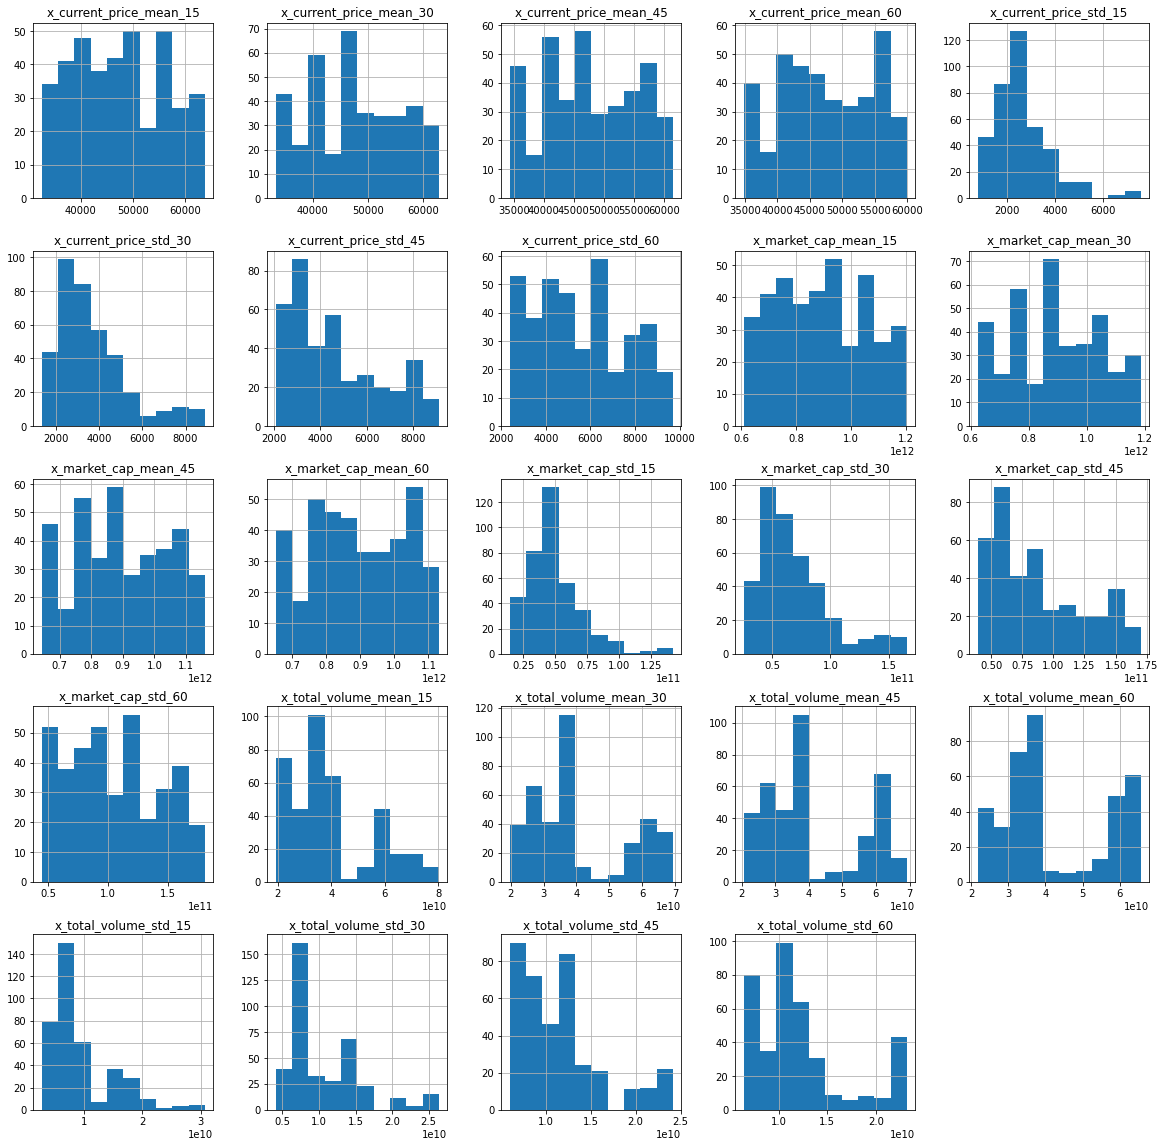

In [21]:
X[varc].hist(figsize=(20,20));

In [22]:
for v,li,ls in X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
    
X['ex_'] = X.filter(like= 'ex_').max(axis=1)
X = X.loc[X['ex_']==0].reset_index(drop=True)
X.drop(X.filter(like='ex_').columns,axis=1,inplace=True)

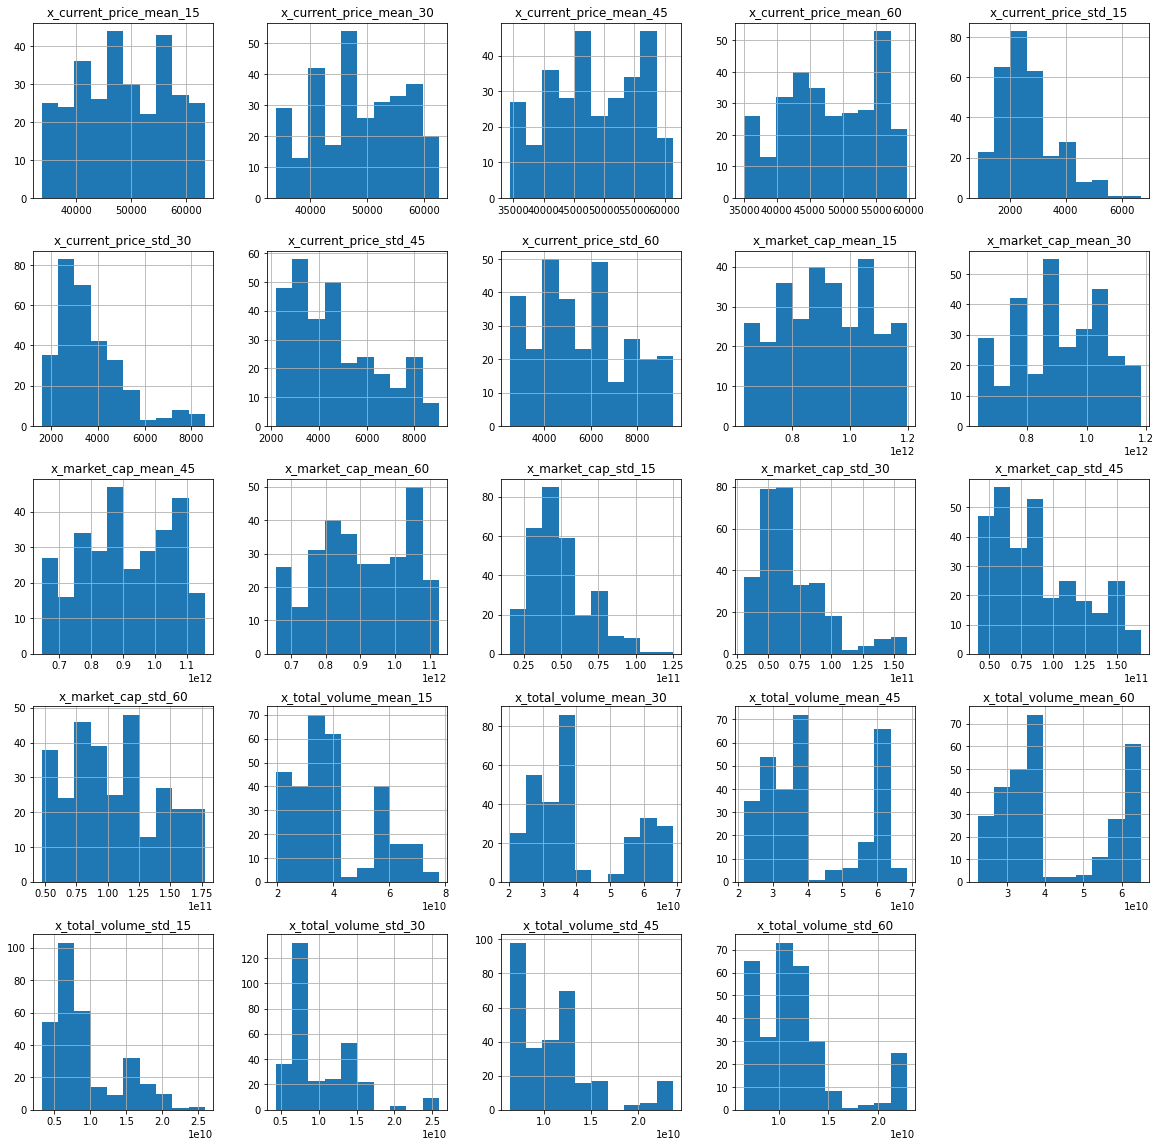

In [23]:
X[varc].hist(figsize=(20,20));

### Multicollinearity

In [24]:
X[varc].corr()

t,x_current_price_mean_15,x_current_price_mean_30,x_current_price_mean_45,x_current_price_mean_60,x_current_price_std_15,x_current_price_std_30,x_current_price_std_45,x_current_price_std_60,x_market_cap_mean_15,x_market_cap_mean_30,...,x_market_cap_std_45,x_market_cap_std_60,x_total_volume_mean_15,x_total_volume_mean_30,x_total_volume_mean_45,x_total_volume_mean_60,x_total_volume_std_15,x_total_volume_std_30,x_total_volume_std_45,x_total_volume_std_60
t,,,,,,,,,,,,,,,,,,,,,
x_current_price_mean_15,1.000000,0.947633,0.835884,0.679774,0.147366,0.203705,0.240105,0.172575,0.999522,0.944996,...,0.243924,0.180492,0.537208,0.485282,0.414589,0.351998,0.193576,0.020211,-0.205704,-0.295723
x_current_price_mean_30,0.947633,1.000000,0.950745,0.836710,0.116579,0.136676,0.191963,0.150848,0.948546,0.999453,...,0.193325,0.156686,0.531861,0.511637,0.448482,0.388512,0.312653,0.147295,-0.093719,-0.203621
x_current_price_mean_45,0.835884,0.950745,1.000000,0.956262,0.121211,0.119502,0.126709,0.106958,0.839209,0.953271,...,0.126062,0.110224,0.456101,0.463155,0.429088,0.378252,0.334929,0.242183,0.020448,-0.105587
x_current_price_mean_60,0.679774,0.836710,0.956262,1.000000,0.089779,0.112931,0.102031,0.077762,0.686038,0.842884,...,0.099875,0.078680,0.335027,0.361138,0.356529,0.328253,0.339334,0.270820,0.122852,0.002318
x_current_price_std_15,0.147366,0.116579,0.121211,0.089779,1.000000,0.359714,-0.017222,-0.160530,0.142332,0.110461,...,-0.021234,-0.163606,0.368238,0.263832,0.263681,0.222224,0.276256,0.182130,0.128473,-0.076017
x_current_price_std_30,0.203705,0.136676,0.119502,0.112931,0.359714,1.000000,0.555294,0.160584,0.203294,0.135126,...,0.554784,0.160409,0.232237,0.223497,0.165104,0.138818,0.088890,0.213433,0.081535,-0.072612
x_current_price_std_45,0.240105,0.191963,0.126709,0.102031,-0.017222,0.555294,1.000000,0.690595,0.238362,0.189740,...,0.999876,0.691753,0.190497,0.277776,0.243924,0.210020,0.012863,0.273894,0.269724,0.142760
x_current_price_std_60,0.172575,0.150848,0.106958,0.077762,-0.160530,0.160584,0.690595,1.000000,0.167890,0.145370,...,0.689934,0.999873,0.209371,0.302559,0.357022,0.341020,0.069286,0.261107,0.485159,0.458373
x_market_cap_mean_15,0.999522,0.948546,0.839209,0.686038,0.142332,0.203294,0.238362,0.167890,1.000000,0.946925,...,0.242432,0.176049,0.513701,0.461207,0.390102,0.326890,0.187805,0.009911,-0.218927,-0.311176


In [25]:
vc = VarClusHi(df=X,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = rs.loc[rs['id']==1]['Variable'].tolist()
#best=['x_current_price_mean_45','x_total_volume_mean_30', 'x_market_cap_std_60',
#      'x_current_price_std_30','x_total_volume_std_60', 'x_market_cap_std_15']
best

['x_current_price_mean_45',
 'x_total_volume_mean_45',
 'x_market_cap_std_60',
 'x_current_price_std_15',
 'x_current_price_std_30',
 'x_total_volume_std_45']

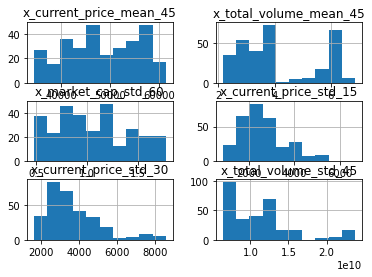

In [26]:
X[best].hist();

In [27]:
X[best].corr()

t,x_current_price_mean_45,x_total_volume_mean_45,x_market_cap_std_60,x_current_price_std_15,x_current_price_std_30,x_total_volume_std_45
t,,,,,,
x_current_price_mean_45,1.000000,0.429088,0.110224,0.121211,0.119502,0.020448
x_total_volume_mean_45,0.429088,1.000000,0.350401,0.263681,0.165104,0.583377
x_market_cap_std_60,0.110224,0.350401,1.000000,-0.163606,0.160409,0.474526
x_current_price_std_15,0.121211,0.263681,-0.163606,1.000000,0.359714,0.128473
x_current_price_std_30,0.119502,0.165104,0.160409,0.359714,1.000000,0.081535
x_total_volume_std_45,0.020448,0.583377,0.474526,0.128473,0.081535,1.000000


## Scaler and Split

In [28]:
um=['symbol','ancla']

tad = X[um+best].merge(Y,on=um,how='left')
varc = sorted(tad.filter(like='x_').columns)
vart = ['tgt']

Summary of our dataframe

In [29]:
completitud=pd.DataFrame((1-tad.isnull().sum()/tad.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(tad.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(tad.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,symbol,100.0,0,object
1,ancla,100.0,0,int64
2,x_current_price_mean_45,100.0,0,float64
3,x_total_volume_mean_45,100.0,0,float64
4,x_market_cap_std_60,100.0,0,float64
5,x_current_price_std_15,100.0,0,float64
6,x_current_price_std_30,100.0,0,float64
7,x_total_volume_std_45,100.0,0,float64
8,tgt,100.0,0,int64


In [43]:
%%writefile transform.py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class scaler_split(object):
    
    def __init__(self, df,X,Y):
        self.df = df
        self.X = X
        self.Y = Y
        
    def split(self,val,test,rs=None):
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.df[self.X],self.df[self.Y], test_size=test,random_state=rs)
        self.X_train, self.X_val, self.Y_train, self.Y_val = train_test_split(self.X_train,self.Y_train, test_size=val/(1-test),random_state=rs)
    
    def scaler(self, scaler='MinMaxScaler'):
        
        if scaler=='MinMaxScaler':
            scalerc = MinMaxScaler()
            self.X_train = scalerc.fit_transform(self.X_train)
            self.X_val = scalerc.transform(self.X_val)
            self.X_test = scalerc.transform(self.X_test)
            return scalerc
        else:
            if scaler=='StandardScaler':
                scalerc = StandardScaler()
                self.X_train = scalerc.fit_transform(self.X_train)
                self.X_val = scalerc.transform(self.X_val)
                self.X_test = scalerc.transform(self.X_test)
                return scalerc
            else:
                print('Supported values: "MinMaxScaler", "StandardScaler"')
                return None

Overwriting transform.py


In [44]:
!gsutil cp transform.py gs://crispy-bucket-2022/models/utils/transform.py
!gsutil cp gs://crispy-bucket-2022/models/utils/transform.py transform.py

Copying file://transform.py [Content-Type=text/x-python]...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      
Copying gs://crispy-bucket-2022/models/utils/transform.py...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      


In [31]:
from transform import scaler_split

sp=scaler_split(df=tad,X=best,Y=vart)
sp.split(val=0.1,test=0.1,rs=220327)
sc = sp.scaler('MinMaxScaler')

with open('scaler_v1.pkl', 'wb') as f:
    pickle.dump(sc,f)

## Build and train our model

In [116]:
checkpoints = ModelCheckpoint("model_v1.h5",monitor='val_loss',verbose=10,save_best_only=True,
                              save_weights_only=False,mode="min",save_freq='epoch')

DNN = Sequential()
DNN.add(InputLayer(input_shape=sp.X_train.shape[1]))
DNN.add(Dense(2048, activation='relu'))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(1024, activation='relu',kernel_regularizer = l1_l2(0.001, 0.001)))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(256, activation='LeakyReLU'))
DNN.add(BatchNormalization())
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(16, activation='LeakyReLU',kernel_regularizer = l1_l2(0.01, 0.01)))
DNN.add(Dense(units=sp.Y_train.shape[1], activation='sigmoid'))
DNN.compile(optimizer=Adam(0.0001), loss= BinaryCrossentropy(),metrics=['accuracy','AUC'])
DNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2048)              14336     
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [117]:
DNN.fit(x=sp.X_train, y=sp.Y_train, batch_size=16, epochs=300, validation_data=(sp.X_val, sp.Y_val),callbacks=[checkpoints])

Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 48.8247 - accuracy: 0.5833 - auc: 0.5704
Epoch 1: val_loss improved from inf to 47.46914, saving model to model_v1.h5
15/15 [==============================] - 3s 99ms/step - loss: 48.8247 - accuracy: 0.5833 - auc: 0.5704 - val_loss: 47.4691 - val_accuracy: 0.9677 - val_auc: 0.8500
Epoch 2/300
15/15 [==============================] - ETA: 0s - loss: 46.1790 - accuracy: 0.8042 - auc: 0.7324
Epoch 2: val_loss improved from 47.46914 to 44.93225, saving model to model_v1.h5
15/15 [==============================] - 1s 73ms/step - loss: 46.1790 - accuracy: 0.8042 - auc: 0.7324 - val_loss: 44.9322 - val_accuracy: 0.9677 - val_auc: 0.8833
Epoch 3/300
15/15 [==============================] - ETA: 0s - loss: 43.6426 - accuracy: 0.8042 - auc: 0.7233
Epoch 3: val_loss improved from 44.93225 to 42.44782, saving model to model_v1.h5
15/15 [==============================] - 1s 76ms/step - loss: 43.6426 - accuracy: 0.8042 - auc: 0.723

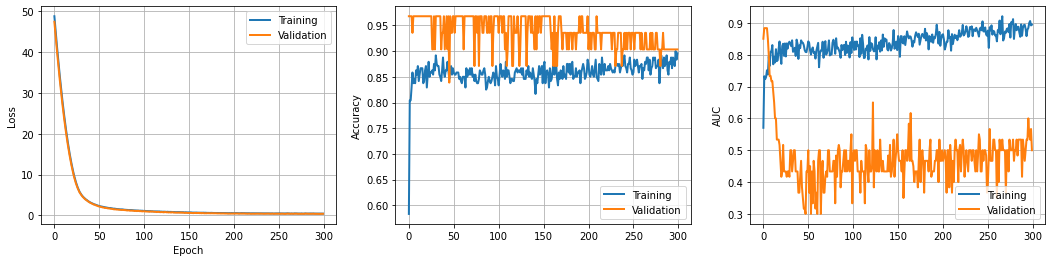

In [118]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['auc'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_auc'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('AUC')
plt.grid(True)

plt.show()

In [138]:
model = load_model("model_v1.h5")

In [139]:
test_loss = model.evaluate(x=sp.X_test, y=sp.Y_test, verbose=True)

1/1 [==============================] - 0s 319ms/step - loss: 0.6669 - accuracy: 0.8065 - auc: 0.7446


## Packaging in a Docker container